In [2]:
import pandas as pd 
data = pd.read_csv("Data/btc.csv")
data.head()

,date,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,...,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d
0,2009-01-03,0,0,0,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2009-01-04,0,0,0,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,2009-01-05,0,0,0,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,2009-01-06,0,0,0,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,2009-01-07,0,0,0,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [3]:
data = data[['date', 'HashRate', 'PriceUSD']]
data = data[data['date']>= '2015-01-01']
data

,date,HashRate,PriceUSD
2189,2015-01-01,3.333450e+05,314.776472
2190,2015-01-02,3.333450e+05,315.942732
2191,2015-01-03,3.272842e+05,285.647310
2192,2015-01-04,3.474869e+05,263.334575
2193,2015-01-05,3.151626e+05,275.003852
...,...,...,...
4185,2020-06-19,1.122069e+08,9285.991583
4186,2020-06-20,1.074990e+08,9357.292464
4187,2020-06-21,1.145609e+08,9284.769372
4188,2020-06-22,1.122069e+08,9684.620185


### Identify time periods that saw a significant increase in price

In [4]:
# compute 2 week average price

data_weekly = data[['date', 'HashRate', 'PriceUSD']]
data_weekly['date'] =  pd.to_datetime(data_weekly['date'])

weekly_data = data_weekly.resample('2W-Wed', label='right', closed = 'right', on='date').mean().reset_index().sort_values(by='date')

weekly_data

,date,HashRate,PriceUSD
0,2015-01-07,3.226664e+05,291.398575
1,2015-01-21,3.031568e+05,234.128920
2,2015-02-04,3.026833e+05,239.054890
3,2015-02-18,3.277332e+05,229.983642
4,2015-03-04,3.411133e+05,251.935578
...,...,...,...
139,2020-05-06,1.169369e+08,8360.196726
140,2020-05-20,1.046658e+08,9434.304073
141,2020-06-03,9.836462e+07,9329.567917
142,2020-06-17,1.125320e+08,9589.770179


In [6]:
# calculate percentage increase in price as compared to the previous period
# convert to spark to use spark sql

import pyspark
from pyspark.sql import SparkSession
sp = SparkSession.builder.appName("btc").getOrCreate()

btc_spark = sp.createDataFrame(weekly_data)
btc_spark.createOrReplaceTempView("btc_spark")
btc_price = sp.sql("SELECT substr(date, 1,10) as 2weeks_ending, PriceUSD FROM btc_spark")

# create a new column containing the previous price information
btc_price.createOrReplaceTempView("btc_price")
tmp = sp.sql("SELECT 2weeks_ending, PriceUSD, LAG(PriceUSD, 1) OVER (ORDER BY 2weeks_ending) AS prev_price FROM btc_price")

# estimate percentage growth from previous timeperiod's price
tmp.createOrReplaceTempView("tmp")
tmp2 = sp.sql("SELECT *, ((PriceUSD - prev_price)/prev_price)*100 AS percentage_change FROM tmp")

# identify time periods with greater than 20% increase in price
tmp2.createOrReplaceTempView("tmp2")
focus_timeperiods = sp.sql("SELECT * FROM tmp2 WHERE percentage_change >= 20.000 ORDER BY percentage_change DESC")
focus_timeperiods.show()

+-------------+------------------+------------------+------------------+
|2weeks_ending|          PriceUSD|        prev_price| percentage_change|
+-------------+------------------+------------------+------------------+
|   2017-12-20|17211.659870814903|10292.328724263174| 67.22804267065501|
|   2017-12-06|10292.328724263174| 7305.142839170911|40.891546556415996|
|   2019-05-22| 7504.610916836436| 5453.054784979543| 37.62214415134635|
|   2019-07-03|11160.463888759698|  8422.19437175002|32.512542410496536|
|   2017-08-16|3581.7687784420145|2721.7268002421306|31.599129571835526|
|   2017-10-25| 5735.130768452034|4430.5749036486595| 29.44439250375948|
|   2015-11-11| 357.2740419971612| 276.1767940583619|29.364251335925694|
|   2017-05-24|1937.4007807025957|1514.9831088315095|27.882665450764826|
|   2016-06-22| 681.8896714473574| 542.3242654921933| 25.73467846372313|
|   2017-06-07|2416.9794377619605|1937.4007807025957|24.753714452692964|
|   2017-05-10|1514.9831088315095| 1222.14423915838

## For the periods with a significant increase in price, how long does it take for hashrate to increase in a similar way?

In [14]:
# create a pandas dataframe that contains hashrate for each week

hashrate_data = data[['date', 'HashRate','PriceUSD']]

# aggregate by week
hashrate_data['date'] =  pd.to_datetime(hashrate_data['date'])
hashrate_data = hashrate_data.resample('1W-Wed', label='right', closed = 'right', on='date').mean().reset_index().sort_values(by='date')
hashrate_data = hashrate_data[['date', 'HashRate']]
hashrate_data

,date,HashRate
0,2015-01-07,3.226664e+05
1,2015-01-14,2.965485e+05
2,2015-01-21,3.097652e+05
3,2015-01-28,2.923379e+05
4,2015-02-04,3.130286e+05
...,...,...
281,2020-05-27,9.288200e+07
282,2020-06-03,1.038472e+08
283,2020-06-10,1.149444e+08
284,2020-06-17,1.101195e+08


In [24]:
# create a column that calculates the moving average of the next four weeks
import numpy as np

for i in range(0,hashrate_data.shape[0]-4):
    hashrate_data.loc[hashrate_data.index[i],'next_4'] = np.round(((hashrate_data.iloc[i+1,1]+ hashrate_data.iloc[i+2,1] +hashrate_data.iloc[i+3,1] + hashrate_data.iloc[i+4, 1])/4),1)
hashrate_data = hashrate_data[['date', 'HashRate', 'next_4']]
hashrate_data

,date,HashRate,next_4
0,2015-01-07,3.226664e+05,302920.1
1,2015-01-14,2.965485e+05,310725.7
2,2015-01-21,3.097652e+05,315208.3
3,2015-01-28,2.923379e+05,326483.2
4,2015-02-04,3.130286e+05,334423.3
...,...,...,...
281,2020-05-27,9.288200e+07,110017975.3
282,2020-06-03,1.038472e+08,NaN
283,2020-06-10,1.149444e+08,NaN
284,2020-06-17,1.101195e+08,NaN


In [114]:
# for a week that showed a significant increase in price, get the average hashrate for the subsequent four weeks with a lag of 'x' weeks
# investigate trends for '2017-12-20'

start_date = '2017-12-20'
end_date = '2018-05-01'
tmp = hashrate_data
tmp['date'] =  pd.to_datetime(tmp['date'])

mask = (tmp['date'] >= start_date) & (tmp['date'] <= end_date)
tmp = tmp.loc[mask]
tmp2 = tmp
tmp2

,date,HashRate,next_4
154,2017-12-20,1.392320e+07,15327746.2
155,2017-12-27,1.344812e+07,16802983.7
156,2018-01-03,1.493043e+07,17932438.3
157,2018-01-10,1.559271e+07,19466950.8
158,2018-01-17,1.733973e+07,20587768.0
159,2018-01-24,1.934907e+07,21280779.1
160,2018-01-31,1.944825e+07,22126331.4
161,2018-02-07,2.173076e+07,22845237.6
162,2018-02-14,2.182300e+07,23605410.7
163,2018-02-21,2.212111e+07,24274219.3


In [116]:
# additional columns to create time series - lag week, base hashrate, % increase

tmp2.shape
base_hashrate = tmp2['HashRate'].iloc[0]

for i in range(0, tmp2.shape[0]):
    tmp2.loc[tmp2.index[i], 'lag'] = str(i)
    tmp2.loc[tmp2.index[i], 'percentage_change_from_base'] = ((tmp2['next_4'].iloc[i]-base_hashrate)/base_hashrate)*100
    tmp2.loc[tmp2.index[i], '%_next4_change'] = ((tmp2['next_4'].iloc[i] - tmp2['HashRate'].iloc[i])/tmp2['HashRate'].iloc[i])*100
for i in range(1, tmp2.shape[0]):
    tmp2.loc[tmp2.index[i], '%change_in_HashRate'] = ((tmp2['HashRate'].iloc[i] - tmp2['HashRate'].iloc[i-1])/tmp2['HashRate'].iloc[i-1])*100
    
tmp2 = tmp2[['date', 'HashRate', 'next_4', 'lag', 'percentage_change_from_base', '%change_in_HashRate', '%_next4_change']]
tmp2

,date,HashRate,next_4,lag,percentage_change_from_base,%change_in_HashRate,%_next4_change
154,2017-12-20,1.392320e+07,15327746.2,0,10.087792,NaN,10.087792
155,2017-12-27,1.344812e+07,16802983.7,1,20.683325,-3.412188,24.946743
156,2018-01-03,1.493043e+07,17932438.3,2,28.795356,11.022475,20.106628
157,2018-01-10,1.559271e+07,19466950.8,3,39.816617,4.435737,24.846516
158,2018-01-17,1.733973e+07,20587768.0,4,47.866613,11.204105,18.731770
159,2018-01-24,1.934907e+07,21280779.1,5,52.843996,11.588053,9.983491
160,2018-01-31,1.944825e+07,22126331.4,6,58.916969,0.512602,13.770293
161,2018-02-07,2.173076e+07,22845237.6,7,64.080337,11.736305,5.128589
162,2018-02-14,2.182300e+07,23605410.7,8,69.540094,0.424477,8.167587
163,2018-02-21,2.212111e+07,24274219.3,9,74.343649,1.366050,9.733272


## Line plots for the three metrics




#### 1) This plot illustrates how Average Network Hashrate over a 4-week period changes after a lag of 'x' weeks (from the week that saw an increase in price)
* Average Network Hashrate over a moving 4-week window is compared to the Base Hashrate (Hashrate for the week that saw a significant increase in price)

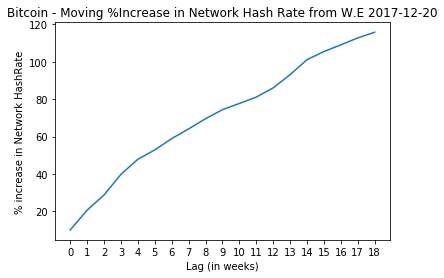

In [117]:
# line plot of percentage change from base hashrate

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% increase in Network HashRate")
plt.title("Bitcoin - Moving %Increase in Network Hash Rate from W.E 2017-12-20")

plt.plot(tmp2['lag'], tmp2['percentage_change_from_base'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

#### 2) This plots % change in weekly network hashrate after the week that showed an increase in price
* how is hashrate growth impacted by a significant increase in price

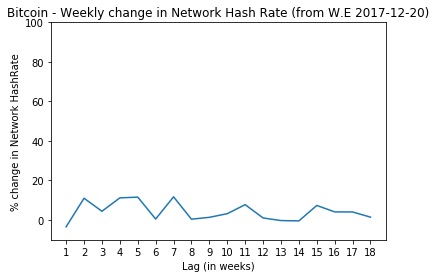

In [118]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% change in Network HashRate")
plt.title("Bitcoin - Weekly change in Network Hash Rate (from W.E 2017-12-20)")
plt.ylim([-10,100])
plt.plot(tmp2['lag'], tmp2['%change_in_HashRate'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

#### 3) This plot illustrates how Average Network Hashrate for a moving window of 4 weeks compares to Week (base + lag). x-axis represents lag in weeks and y-axis is the percentage change
* This plot helps answer the question "How much of a lag do we notice before there is substantial growth in Network Hashrate over a period of 4 weeks as compared to the present week"

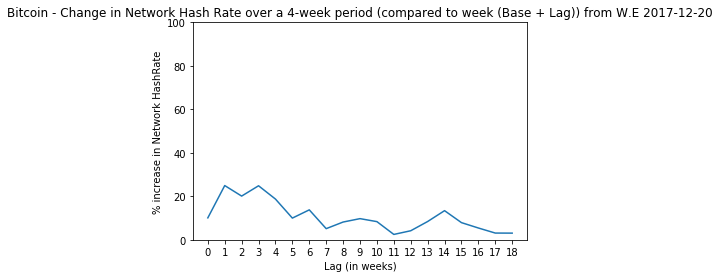

In [119]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% increase in Network HashRate")
plt.title("Bitcoin - Change in Network Hash Rate over a 4-week period (compared to week (Base + Lag)) from W.E 2017-12-20")
plt.ylim([0,100])
plt.plot(tmp2['lag'], tmp2['%_next4_change'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

## Repeat the process to create similar plots for other 2-week periods that saw an increase in price

### Plots for W.E. '2017-12-06'

In [122]:
# for a week that showed a significant increase in price, get the average hashrate for the subsequent four weeks with a lag of 'x' weeks
# investigate trends for '2017-12-06'

start_date = '2017-12-06'
end_date = '2018-04-28'
tmp = hashrate_data
tmp['date'] =  pd.to_datetime(tmp['date'])

mask = (tmp['date'] >= start_date) & (tmp['date'] <= end_date)
tmp = tmp.loc[mask]
tmp2 = tmp
tmp2

,date,HashRate,next_4
152,2017-12-06,1.189412e+07,13848947.0
153,2017-12-13,1.309404e+07,14473614.4
154,2017-12-20,1.392320e+07,15327746.2
155,2017-12-27,1.344812e+07,16802983.7
156,2018-01-03,1.493043e+07,17932438.3
157,2018-01-10,1.559271e+07,19466950.8
158,2018-01-17,1.733973e+07,20587768.0
159,2018-01-24,1.934907e+07,21280779.1
160,2018-01-31,1.944825e+07,22126331.4
161,2018-02-07,2.173076e+07,22845237.6


In [123]:
tmp2.shape
base_hashrate = tmp2['HashRate'].iloc[0]

for i in range(0, tmp2.shape[0]):
    tmp2.loc[tmp2.index[i], 'lag'] = str(i)
    tmp2.loc[tmp2.index[i], 'percentage_change_from_base'] = ((tmp2['next_4'].iloc[i]-base_hashrate)/base_hashrate)*100
    tmp2.loc[tmp2.index[i], '%_next4_change'] = ((tmp2['next_4'].iloc[i] - tmp2['HashRate'].iloc[i])/tmp2['HashRate'].iloc[i])*100
for i in range(1, tmp2.shape[0]):
    tmp2.loc[tmp2.index[i], '%change_in_HashRate'] = ((tmp2['HashRate'].iloc[i] - tmp2['HashRate'].iloc[i-1])/tmp2['HashRate'].iloc[i-1])*100
    
tmp2 = tmp2[['date', 'HashRate', 'next_4', 'lag', 'percentage_change_from_base', '%change_in_HashRate', '%_next4_change']]
tmp2

,date,HashRate,next_4,lag,percentage_change_from_base,%change_in_HashRate,%_next4_change
152,2017-12-06,1.189412e+07,13848947.0,0,16.435221,NaN,16.435221
153,2017-12-13,1.309404e+07,14473614.4,1,21.687122,10.088303,10.535923
154,2017-12-20,1.392320e+07,15327746.2,2,28.868247,6.332392,10.087792
155,2017-12-27,1.344812e+07,16802983.7,3,41.271328,-3.412188,24.946743
156,2018-01-03,1.493043e+07,17932438.3,4,50.767233,11.022475,20.106628
157,2018-01-10,1.559271e+07,19466950.8,5,63.668669,4.435737,24.846516
158,2018-01-17,1.733973e+07,20587768.0,6,73.091956,11.204105,18.731770
159,2018-01-24,1.934907e+07,21280779.1,7,78.918457,11.588053,9.983491
160,2018-01-31,1.944825e+07,22126331.4,8,86.027450,0.512602,13.770293
161,2018-02-07,2.173076e+07,22845237.6,9,92.071664,11.736305,5.128589


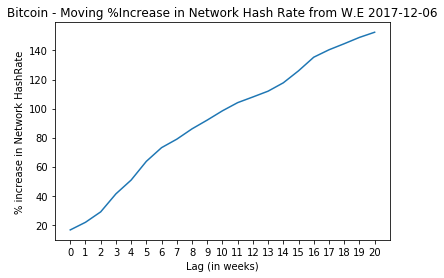

In [124]:
# line plot of percentage change from base hashrate

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% increase in Network HashRate")
plt.title("Bitcoin - Moving %Increase in Network Hash Rate from W.E 2017-12-06")

plt.plot(tmp2['lag'], tmp2['percentage_change_from_base'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

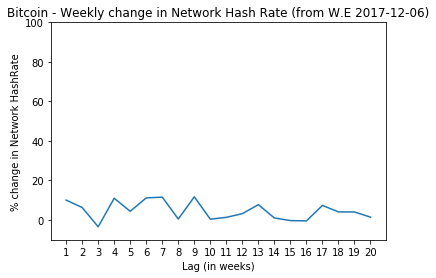

In [125]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% change in Network HashRate")
plt.title("Bitcoin - Weekly change in Network Hash Rate (from W.E 2017-12-06)")
plt.ylim([-10,100])
plt.plot(tmp2['lag'], tmp2['%change_in_HashRate'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

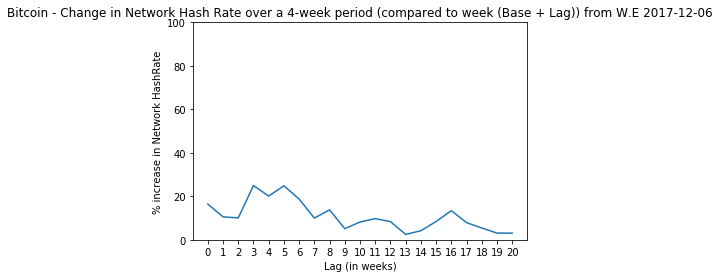

In [126]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% increase in Network HashRate")
plt.title("Bitcoin - Change in Network Hash Rate over a 4-week period (compared to week (Base + Lag)) from W.E 2017-12-06")
plt.ylim([0,100])
plt.plot(tmp2['lag'], tmp2['%_next4_change'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

### Plots for W.E. '2019-05-22'

In [137]:
# for a week that showed a significant increase in price, get the average hashrate for the subsequent four weeks with a lag of 'x' weeks
# investigate trends for '2019-05-22'

start_date = '2019-05-22'
end_date = '2019-09-25'
tmp = hashrate_data
tmp['date'] =  pd.to_datetime(tmp['date'])

mask = (tmp['date'] >= start_date) & (tmp['date'] <= end_date)
tmp = tmp.loc[mask]
tmp2 = tmp
tmp2

,date,HashRate,next_4
228,2019-05-22,5.208229e+07,53830000.5
229,2019-05-29,5.337387e+07,54785367.5
230,2019-06-05,5.176804e+07,57383311.5
231,2019-06-12,5.387525e+07,60533561.5
232,2019-06-19,5.630285e+07,62871900.9
233,2019-06-26,5.719534e+07,64724988.2
234,2019-07-03,6.215981e+07,67172157.7
235,2019-07-10,6.647625e+07,69056918.9
236,2019-07-17,6.565621e+07,70990989.5
237,2019-07-24,6.460769e+07,72911794.9


In [138]:
tmp2.shape
base_hashrate = tmp2['HashRate'].iloc[0]

for i in range(0, tmp2.shape[0]):
    tmp2.loc[tmp2.index[i], 'lag'] = str(i)
    tmp2.loc[tmp2.index[i], 'percentage_change_from_base'] = ((tmp2['next_4'].iloc[i]-base_hashrate)/base_hashrate)*100
    tmp2.loc[tmp2.index[i], '%_next4_change'] = ((tmp2['next_4'].iloc[i] - tmp2['HashRate'].iloc[i])/tmp2['HashRate'].iloc[i])*100
for i in range(1, tmp2.shape[0]):
    tmp2.loc[tmp2.index[i], '%change_in_HashRate'] = ((tmp2['HashRate'].iloc[i] - tmp2['HashRate'].iloc[i-1])/tmp2['HashRate'].iloc[i-1])*100
    
tmp2 = tmp2[['date', 'HashRate', 'next_4', 'lag', 'percentage_change_from_base', '%change_in_HashRate', '%_next4_change']]
tmp2

,date,HashRate,next_4,lag,percentage_change_from_base,%change_in_HashRate,%_next4_change
228,2019-05-22,5.208229e+07,53830000.5,0,3.355670,NaN,3.355670
229,2019-05-29,5.337387e+07,54785367.5,1,5.190011,2.479878,2.644551
230,2019-06-05,5.176804e+07,57383311.5,2,10.178163,-3.008651,10.846995
231,2019-06-12,5.387525e+07,60533561.5,3,16.226764,4.070488,12.358764
232,2019-06-19,5.630285e+07,62871900.9,4,20.716466,4.505975,11.667347
233,2019-06-26,5.719534e+07,64724988.2,5,24.274465,1.585150,13.164800
234,2019-07-03,6.215981e+07,67172157.7,6,28.973124,8.679859,8.063645
235,2019-07-10,6.647625e+07,69056918.9,7,32.591938,6.944094,3.882097
236,2019-07-17,6.565621e+07,70990989.5,8,36.305428,-1.233579,8.125325
237,2019-07-24,6.460769e+07,72911794.9,9,39.993448,-1.596991,12.853129


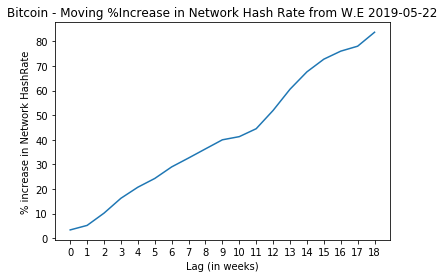

In [144]:
# line plot of percentage change from base hashrate

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% increase in Network HashRate")
plt.title("Bitcoin - Moving %Increase in Network Hash Rate from W.E 2019-05-22")

plt.plot(tmp2['lag'], tmp2['percentage_change_from_base'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

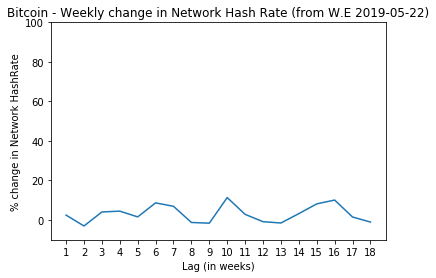

In [145]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% change in Network HashRate")
plt.title("Bitcoin - Weekly change in Network Hash Rate (from W.E 2019-05-22)")
plt.ylim([-10,100])
plt.plot(tmp2['lag'], tmp2['%change_in_HashRate'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

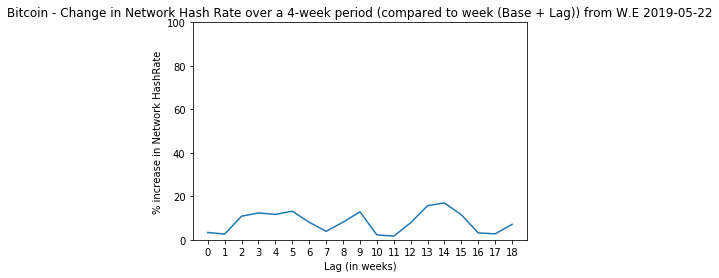

In [146]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% increase in Network HashRate")
plt.title("Bitcoin - Change in Network Hash Rate over a 4-week period (compared to week (Base + Lag)) from W.E 2019-05-22")
plt.ylim([0,100])
plt.plot(tmp2['lag'], tmp2['%_next4_change'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

### Plots for W.E. '2019-07-03'

In [152]:
# for a week that showed a significant increase in price, get the average hashrate for the subsequent four weeks with a lag of 'x' weeks
# investigate trends for '2019-07-03'

start_date = '2019-07-03'
end_date = '2019-10-25'
tmp = hashrate_data
tmp['date'] =  pd.to_datetime(tmp['date'])

mask = (tmp['date'] >= start_date) & (tmp['date'] <= end_date)
tmp = tmp.loc[mask]
tmp2 = tmp
tmp2

,date,HashRate,next_4
234,2019-07-03,6.215981e+07,67172157.7
235,2019-07-10,6.647625e+07,69056918.9
236,2019-07-17,6.565621e+07,70990989.5
237,2019-07-24,6.460769e+07,72911794.9
238,2019-07-31,7.194849e+07,73582641.3
239,2019-08-07,7.401529e+07,75260653.0
240,2019-08-14,7.339249e+07,79134902.7
241,2019-08-21,7.229091e+07,83625722.6
242,2019-08-28,7.463187e+07,87302310.8
243,2019-09-04,8.072734e+07,89986659.3


In [153]:
tmp2.shape
base_hashrate = tmp2['HashRate'].iloc[0]

for i in range(0, tmp2.shape[0]):
    tmp2.loc[tmp2.index[i], 'lag'] = str(i)
    tmp2.loc[tmp2.index[i], 'percentage_change_from_base'] = ((tmp2['next_4'].iloc[i]-base_hashrate)/base_hashrate)*100
    tmp2.loc[tmp2.index[i], '%_next4_change'] = ((tmp2['next_4'].iloc[i] - tmp2['HashRate'].iloc[i])/tmp2['HashRate'].iloc[i])*100
for i in range(1, tmp2.shape[0]):
    tmp2.loc[tmp2.index[i], '%change_in_HashRate'] = ((tmp2['HashRate'].iloc[i] - tmp2['HashRate'].iloc[i-1])/tmp2['HashRate'].iloc[i-1])*100
    
tmp2 = tmp2[['date', 'HashRate', 'next_4', 'lag', 'percentage_change_from_base', '%change_in_HashRate', '%_next4_change']]
tmp2

,date,HashRate,next_4,lag,percentage_change_from_base,%change_in_HashRate,%_next4_change
234,2019-07-03,6.215981e+07,67172157.7,0,8.063645,NaN,8.063645
235,2019-07-10,6.647625e+07,69056918.9,1,11.095767,6.944094,3.882097
236,2019-07-17,6.565621e+07,70990989.5,2,14.207215,-1.233579,8.125325
237,2019-07-24,6.460769e+07,72911794.9,3,17.297324,-1.596991,12.853129
238,2019-07-31,7.194849e+07,73582641.3,4,18.376552,11.362121,2.271281
239,2019-08-07,7.401529e+07,75260653.0,5,21.076064,2.872614,1.682573
240,2019-08-14,7.339249e+07,79134902.7,6,27.308789,-0.841447,7.824248
241,2019-08-21,7.229091e+07,83625722.6,7,34.533424,-1.500950,15.679448
242,2019-08-28,7.463187e+07,87302310.8,8,40.448160,3.238260,16.977245
243,2019-09-04,8.072734e+07,89986659.3,9,44.766623,8.167373,11.469870


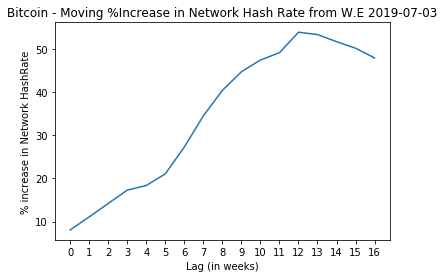

In [154]:
# line plot of percentage change from base hashrate

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% increase in Network HashRate")
plt.title("Bitcoin - Moving %Increase in Network Hash Rate from W.E 2019-07-03")

plt.plot(tmp2['lag'], tmp2['percentage_change_from_base'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

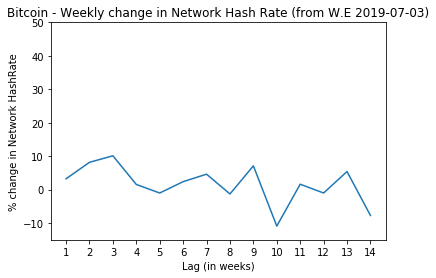

In [163]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% change in Network HashRate")
plt.title("Bitcoin - Weekly change in Network Hash Rate (from W.E 2019-07-03)")
plt.ylim([-15,50])
plt.plot(tmp2['lag'], tmp2['%change_in_HashRate'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

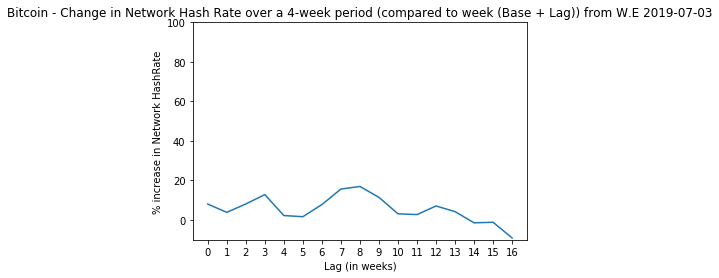

In [158]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% increase in Network HashRate")
plt.title("Bitcoin - Change in Network Hash Rate over a 4-week period (compared to week (Base + Lag)) from W.E 2019-07-03")
plt.ylim([-10,100])
plt.plot(tmp2['lag'], tmp2['%_next4_change'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

### Plots for W.E. '2017-08-16'

In [160]:
# for a week that showed a significant increase in price, get the average hashrate for the subsequent four weeks with a lag of 'x' weeks
# investigate trends for '2019-08-16'

start_date = '2019-08-16'
end_date = '2019-11-30'
tmp = hashrate_data
tmp['date'] =  pd.to_datetime(tmp['date'])

mask = (tmp['date'] >= start_date) & (tmp['date'] <= end_date)
tmp = tmp.loc[mask]
tmp2 = tmp
tmp2

,date,HashRate,next_4
241,2019-08-21,7.229091e+07,83625722.6
242,2019-08-28,7.463187e+07,87302310.8
243,2019-09-04,8.072734e+07,89986659.3
244,2019-09-11,8.888949e+07,91686234.2
245,2019-09-18,9.025419e+07,92734937.0
246,2019-09-25,8.933823e+07,95689627.7
247,2019-10-02,9.146473e+07,95356403.2
248,2019-10-09,9.568779e+07,94332025.2
249,2019-10-16,9.444900e+07,93385994.4
250,2019-10-23,1.011570e+08,91989216.7


In [161]:
tmp2.shape
base_hashrate = tmp2['HashRate'].iloc[0]

for i in range(0, tmp2.shape[0]):
    tmp2.loc[tmp2.index[i], 'lag'] = str(i)
    tmp2.loc[tmp2.index[i], 'percentage_change_from_base'] = ((tmp2['next_4'].iloc[i]-base_hashrate)/base_hashrate)*100
    tmp2.loc[tmp2.index[i], '%_next4_change'] = ((tmp2['next_4'].iloc[i] - tmp2['HashRate'].iloc[i])/tmp2['HashRate'].iloc[i])*100
for i in range(1, tmp2.shape[0]):
    tmp2.loc[tmp2.index[i], '%change_in_HashRate'] = ((tmp2['HashRate'].iloc[i] - tmp2['HashRate'].iloc[i-1])/tmp2['HashRate'].iloc[i-1])*100
    
tmp2 = tmp2[['date', 'HashRate', 'next_4', 'lag', 'percentage_change_from_base', '%change_in_HashRate', '%_next4_change']]
tmp2

,date,HashRate,next_4,lag,percentage_change_from_base,%change_in_HashRate,%_next4_change
241,2019-08-21,7.229091e+07,83625722.6,0,15.679448,NaN,15.679448
242,2019-08-28,7.463187e+07,87302310.8,1,20.765272,3.238260,16.977245
243,2019-09-04,8.072734e+07,89986659.3,2,24.478531,8.167373,11.469870
244,2019-09-11,8.888949e+07,91686234.2,3,26.829552,10.110766,3.146315
245,2019-09-18,9.025419e+07,92734937.0,4,28.280223,1.535273,2.748626
246,2019-09-25,8.933823e+07,95689627.7,5,32.367446,-1.014866,7.109387
247,2019-10-02,9.146473e+07,95356403.2,6,31.906497,2.380286,4.254832
248,2019-10-09,9.568779e+07,94332025.2,7,30.489475,4.617143,-1.416863
249,2019-10-16,9.444900e+07,93385994.4,8,29.180830,-1.294619,-1.125479
250,2019-10-23,1.011570e+08,91989216.7,9,27.248668,7.102238,-9.062917


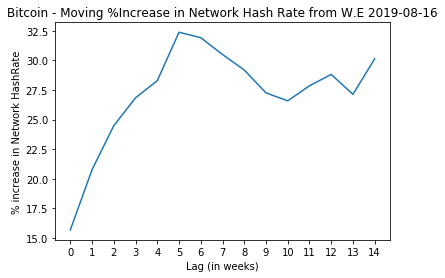

In [167]:
# line plot of percentage change from base hashrate

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% increase in Network HashRate")
plt.title("Bitcoin - Moving %Increase in Network Hash Rate from W.E 2019-08-16")

plt.plot(tmp2['lag'], tmp2['percentage_change_from_base'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

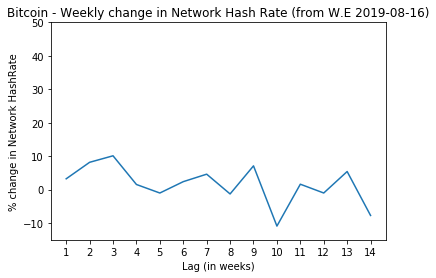

In [168]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% change in Network HashRate")
plt.title("Bitcoin - Weekly change in Network Hash Rate (from W.E 2019-08-16)")
plt.ylim([-15,50])
plt.plot(tmp2['lag'], tmp2['%change_in_HashRate'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()

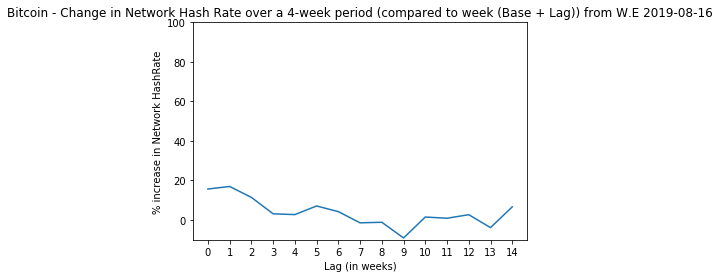

In [169]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

ax = plt.gca()
#formatter = mdates.DateFormatter("%Y-%m-%d")
#ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Lag (in weeks)")
plt.ylabel("% increase in Network HashRate")
plt.title("Bitcoin - Change in Network Hash Rate over a 4-week period (compared to week (Base + Lag)) from W.E 2019-08-16")
plt.ylim([-10,100])
plt.plot(tmp2['lag'], tmp2['%_next4_change'])
#x.xaxis.set_major_locator(mdates.WeekdayLocator())

#plt.xticks(rotation=45)

plt.show()